# 딥러닝을 활용한 시계열 예측 
https://d2.naver.com/helloworld/0065813


LSTM 을 활용해 다음 90일 간의 가스 공급량을 예측해보고자 함

In [1]:
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt 
%matplotlib inline 

plt.rc('font', family = 'AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


df = pd.read_csv('한국가스공사_시간별 공급량_20181231.csv', encoding = 'euc-kr')
test = pd.read_csv('가스공급량 수요예측모델개발_data/test.csv')
sub = pd.read_csv('가스공급량 수요예측모델개발_data/sample_submission.csv')

In [2]:
def tohour(val):
    if len(val) == 1:
        return '0'+val+':00:00'
    else:
        return val+':00:00'

In [3]:
df['시간_수정'] = df['시간'] -1 
df['시간_수정'] = df['시간_수정'].astype(str)
df['시간_수정'] = df['시간_수정'].apply(tohour)
df['연월일시간'] = df['연월일']+' '+df['시간_수정']
df['연월일시간'] = pd.to_datetime(df['연월일시간'])

In [35]:
A = df[df['구분'] =='A']
B = df[df['구분'] =='B']
C = df[df['구분'] =='C']
D = df[df['구분'] =='D']
E = df[df['구분'] =='E']
G = df[df['구분'] =='G']
H = df[df['구분'] =='H']

In [36]:
def gubun(df):
    df = df[['연월일시간','공급량']]
    df.columns = ['ds','y']
    df = df.set_index('ds')
    return df

In [37]:
a = gubun(A)
b = gubun(B)
c = gubun(C)
d = gubun(D)
e = gubun(E)
g = gubun(G)
h = gubun(H)

In [38]:
test['일자'] =test['일자|시간|구분'].str.slice(0,10)
test['시간'] = test['일자|시간|구분'].str.slice(11,13)
test['구분'] = test['일자|시간|구분'].str.slice(14)
test['시간_수정'] = test['시간'].astype(int)-1
test['시간_수정'] =test['시간_수정'].astype(str)
test['시간_수정'] = test['시간_수정'].apply(tohour)
test['연월일시간'] = test['일자'] +' '+ test['시간_수정']
test['연월일시간'] = pd.to_datetime(test['연월일시간'])

In [39]:
def gubun_t(구분):
    a_test = test[test['구분'] ==구분][['연월일시간']]
    a_test.columns =['ds']
    
    return a_test

In [40]:
a_test = gubun_t('A')
b_test = gubun_t('B')
c_test = gubun_t('C')
d_test = gubun_t('D')
e_test = gubun_t('E')
g_test = gubun_t('G')
h_test = gubun_t('H')

# Kaggle : Hourly energy consumption time series RNN, LSTM
https://www.kaggle.com/msripooja/hourly-energy-consumption-time-series-rnn-lstm


In [41]:
a

,y
ds,
2013-01-01 00:00:00,2497.129
2013-01-01 01:00:00,2363.265
2013-01-01 02:00:00,2258.505
2013-01-01 03:00:00,2243.969
2013-01-01 04:00:00,2344.105
...,...
2018-12-31 19:00:00,3040.868
2018-12-31 20:00:00,2973.577
2018-12-31 21:00:00,2840.272


<AxesSubplot:xlabel='ds'>

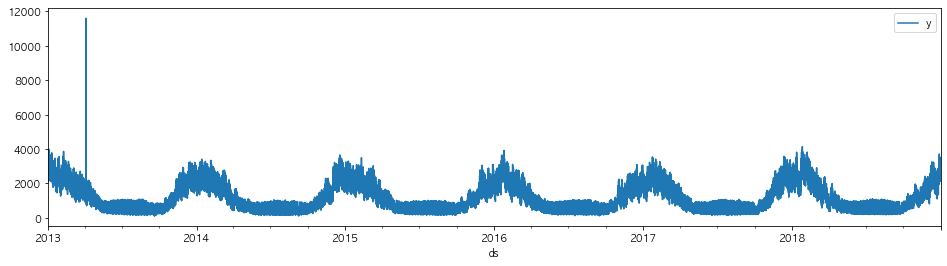

In [42]:
a.plot(figsize = (16,4))

In [13]:
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import r2_score
import tensorflow as tf 
from tensorflow import keras

from tensorflow.keras.layers import Dense, Dropout, SimpleRNN,LSTM
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

In [14]:
def normalize_data(df):
    scaler = MinMaxScaler()
    df['y'] = scaler.fit_transform(df['y'].values.reshape(-1,1))
    return df

In [15]:
df_norm = normalize_data(a)

<AxesSubplot:xlabel='ds'>

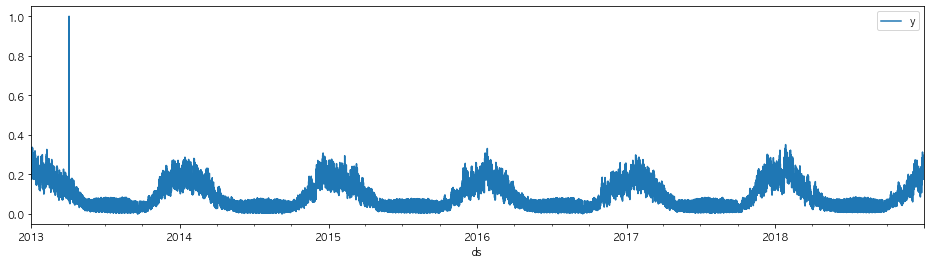

In [15]:
df_norm.plot(figsize = (16,4), legend = True)

#### RNN 모델을 위한 데이터 전처리

In [16]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
        
    # 400일 데이터를 test로 활용  : 400 * 24 = 9600
    X_test = X_train[9600:]
    y_test = y_train[9600:]
    
    # training 
    X_train = X_train[:9600]
    y_train = y_train[:9600]
    
    # to numpy 
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # reshape 
    X_train = np.reshape(X_train, (9600, seq_len, 1))
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]
    

In [43]:
X_train, y_train, X_test, y_test = load_data(a, 90)

In [44]:
X_train.shape

(9600, 90, 1)

In [50]:
X_test

array([[[2379.217],
        [2100.161],
        [1946.265],
        ...,
        [1806.281],
        [1879.849],
        [2112.233]],

       [[2100.161],
        [1946.265],
        [2023.825],
        ...,
        [1879.849],
        [2112.233],
        [2430.081]],

       [[1946.265],
        [2023.825],
        [2226.561],
        ...,
        [2112.233],
        [2430.081],
        [2410.049]],

       ...,

       [[2389.755],
        [2555.288],
        [2787.287],
        ...,
        [2991.729],
        [3040.868],
        [2973.577]],

       [[2555.288],
        [2787.287],
        [3046.463],
        ...,
        [3040.868],
        [2973.577],
        [2840.272]],

       [[2787.287],
        [3046.463],
        [3509.966],
        ...,
        [2973.577],
        [2840.272],
        [2692.385]]])

In [46]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40, activation = 'tanh', return_sequences =True, 
                        input_shape = (X_train.shape[1], 1)))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40, activation = 'tanh', return_sequences =True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40, activation = 'tanh', return_sequences =False))
rnn_model.add(Dropout(0.15))

rnn_model.add(Dense(1))
rnn_model.summary()



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 90, 40)            1680      
_________________________________________________________________
dropout_6 (Dropout)          (None, 90, 40)            0         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 90, 40)            3240      
_________________________________________________________________
dropout_7 (Dropout)          (None, 90, 40)            0         
_________________________________________________________________
simple_rnn_8 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_8 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [47]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=10, batch_size=1000)

Epoch 1/10
10/10 [==============================] - 2s 123ms/step - loss: 2439091.7500
Epoch 2/10
10/10 [==============================] - 1s 123ms/step - loss: 2431491.2500
Epoch 3/10
10/10 [==============================] - 1s 123ms/step - loss: 2426406.5000
Epoch 4/10
10/10 [==============================] - 1s 123ms/step - loss: 2422975.0000
Epoch 5/10
10/10 [==============================] - 1s 122ms/step - loss: 2420203.2500
Epoch 6/10
10/10 [==============================] - 1s 126ms/step - loss: 2418161.0000
Epoch 7/10
10/10 [==============================] - 1s 125ms/step - loss: 2416548.7500
Epoch 8/10
10/10 [==============================] - 1s 124ms/step - loss: 2415146.2500
Epoch 9/10
10/10 [==============================] - 1s 126ms/step - loss: 2413846.5000
Epoch 10/10
10/10 [==============================] - 1s 125ms/step - loss: 2412548.7500


In [48]:
rnn_predictions = rnn_model.predict(X_test)

rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  -2.457647336250547


In [49]:
rnn_predictions

array([[11.405799],
       [11.405799],
       [11.4058  ],
       ...,
       [11.405799],
       [11.405799],
       [11.405799]], dtype=float32)